## Import

In [1]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import os
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nmt.model import EncoderLSTM, DecoderLSTM, DotAttenDecoderLSTM
from nmt.train import train, trainIters
from nmt.infer import infer
from nmt.eval import eval
from nmt.utils import BatchGenerator

## Data Setup

In [3]:
MAX_LENGTH = 25

In [4]:
# set data path
data_dir = os.path.join('datasets', 'nmt_data_vi')
train_source = 'train.vi'
train_target = 'train.en'
train_source_dir = os.path.join(data_dir, train_source)
train_target_dir = os.path.join(data_dir, train_target)

test_source = 'tst2012.vi'
test_target = 'tst2012.en'
test_source_dir = os.path.join(data_dir, test_source)
test_target_dir = os.path.join(data_dir, test_target)

vocab_source = 'vocab.vi'
vocab_target = 'vocab.en'
vocab_source_dir = os.path.join(data_dir, vocab_source)
vocab_target_dir = os.path.join(data_dir, vocab_target)

In [5]:
# load training sets
with open(train_source_dir) as f_source:
    sentences_source = f_source.readlines()
with open(train_target_dir) as f_target:
    sentences_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source training set: {}".format(len(sentences_source)))
print("Total number of sentences in target training set: {}".format(len(sentences_target)))

# load testing sets
with open(test_source_dir) as f_source:
    test_source = f_source.readlines()
with open(test_target_dir) as f_target:
    test_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source testing set: {}".format(len(test_source)))
print("Total number of sentences in target testing set: {}".format(len(test_target)))

Total number of sentences in source training set: 133317
Total number of sentences in target training set: 133317
Total number of sentences in source testing set: 1553
Total number of sentences in target testing set: 1553


In [6]:
# check the longest sentence after sentence truncation
max = 0
for s in sentences_source:
    if len(s) > max:
        max = len(s)
        max_s = s
print("Number of words in the longest sentence in sentences_source: {}".format(max))
print("The longest sentence: \n{}".format(max_s))

Number of words in the longest sentence in sentences_source: 3199
The longest sentence: 
Thula Mama , Thula Mama , Thula Mama , Thula Mama . Trong kí ức tuổi thơ con , qua những giọt lệ nhoè mắt bà , con thấy chân lý trong nụ cười của bà , con thấy chân lý trong nụ cười của bà , xuyên thấu màn đêm u tối trong sự vô tri của con . Ôi , có một người bà đang nằm nghỉ bà ốm đau và trái tim bà rơi lệ . Băn khoăn , băn khoăn , băn khoăn , băn khoăn liệu thế giới này đang đi về đâu . Lẽ nào chuyện trẻ nhỏ phải tự xoay xở lấy là đúng ? Không , không , không , không , không , không . Lẽ nào phiền muộn dồn hết lên mái đầu người phụ nữ già là đúng ? Những người vô danh bất hạnh . Thula Mama Mama , Thula Mama . Thula Mama Mama . Thula Mama , Thula Mama , Thula Mama Mama , Thula Mama . Ngày mai sẽ tốt đẹp hơn . Ngày mai trèo đèo lội suối sẽ dễ hơn , bà ơi . Thula Mama , Thula Mama . Tôi có nên tan vào bài hát này như người đàn ông hát nhạc blues hay một người hát rong . Và rồi từ rất xa , không phải

In [7]:
# Truncate sentences by maximum length
sentences_source = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_source))
sentences_target = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_target))
test_source = list(map(lambda src:src.split()[:MAX_LENGTH], test_source))
test_target = list(map(lambda src:src.split()[:MAX_LENGTH], test_target))

In [8]:
# Delete empty sentences in source and target
i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del sentences_source[i]
        del sentences_target[i]
        i -= 1
    i += 1
print(len(sentences_source))
print(len(sentences_target))

i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del test_source[i]
        del test_target[i]
        i -= 1
    i += 1
print(len(test_source))
print(len(test_target))

133166
133166
1553
1553


In [9]:
# load vocabularies

# build index2word
with open(vocab_source_dir) as f_vocab_source:
    #index2word_source = f_vocab_source.readlines()
    index2word_source = [line.rstrip() for line in f_vocab_source]
with open(vocab_target_dir) as f_vocab_target:
    #index2word_target = f_vocab_target.readlines()
    index2word_target = [line.rstrip() for line in f_vocab_target]

# build word2index
word2index_source = {}
for idx, word in enumerate(index2word_source):
    word2index_source[word] = idx
word2index_target = {}
for idx, word in enumerate(index2word_target):
    word2index_target[word] = idx
    
# check vocabularies size    
source_vocab_size = len(index2word_source)
target_vocab_size = len(index2word_target)
print("Total nummber of words in source vocabulary: {}".format(len(index2word_source)))
print("Total nummber of words in target vocabulary: {}".format(len(index2word_target)))    

Total nummber of words in source vocabulary: 7709
Total nummber of words in target vocabulary: 17191


## Parameters Setup

In [10]:
# misc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# encoder & decoder init
input_size = source_vocab_size
output_size = target_vocab_size+1 # +1 is a wordaround for ignore_index field of NLLLoss
hidden_size = 512
dropout = 0.2
attention_vector_size = 256
init_weight = 0.1

# train & test & infer
PAD_token = target_vocab_size # this padding token is ignored for loss calculation
SOS_token = 1
EOS_token = 2
batch_size = 128
max_norm = 200
num_step = 30000

## Training

In [11]:
batch_generator_train = BatchGenerator(batch_size, sentences_source, sentences_target, word2index_source, word2index_target, EOS_token, device)
batch_generator_test = BatchGenerator(batch_size, test_source, test_target, word2index_source, word2index_target, EOS_token, device)

encoder1 = EncoderLSTM(input_size, hidden_size, dropout=dropout, init_weight=init_weight).to(device)
decoder1 = DotAttenDecoderLSTM(hidden_size, output_size, attention_vector_size, dropout=dropout, init_weight=init_weight).to(device) 

bleu_params = {}
bleu_params['sentences_source'] = test_source
bleu_params['sentences_ref'] = test_target
bleu_params['max_length'] = MAX_LENGTH
bleu_params['word2index_source'] = word2index_source
bleu_params['word2index_target'] = word2index_target
bleu_params['index2word_target'] = index2word_target
bleu_params['EOS_token'] = EOS_token

In [12]:
plot_losses_train, plot_losses_test, plot_bleu = trainIters(batch_generator_train, batch_generator_test, encoder1, decoder1, num_step, batch_size, device, SOS_token, PAD_token, print_every=100, step_every_epoch = 1000, learning_rate=0.001, bleu_params=bleu_params, max_norm=max_norm)

(step:100 0%) loss_train:6.3767, loss_test:5.7766
(step:200 0%) loss_train:5.6909, loss_test:5.3621
(step:300 1%) loss_train:5.3800, loss_test:5.0841
(step:400 1%) loss_train:5.2154, loss_test:4.9794
(step:500 1%) loss_train:5.0951, loss_test:4.7805
(step:600 2%) loss_train:4.9910, loss_test:4.9051
(step:700 2%) loss_train:4.9336, loss_test:4.6659
(step:800 2%) loss_train:4.8400, loss_test:4.6213
(step:900 3%) loss_train:4.7270, loss_test:4.5760
(step:1000 3%) loss_train:4.6390, loss_test:4.3149
epoch: 1
bleu_test:0.032692169458350656
(step:1100 3%) loss_train:4.5293, loss_test:4.3352
(step:1200 4%) loss_train:4.4541, loss_test:4.2886
(step:1300 4%) loss_train:4.3858, loss_test:4.1842
(step:1400 4%) loss_train:4.3268, loss_test:4.1443
(step:1500 5%) loss_train:4.2766, loss_test:4.1260
(step:1600 5%) loss_train:4.2222, loss_test:4.0781
(step:1700 5%) loss_train:4.1893, loss_test:4.0020
(step:1800 6%) loss_train:4.1405, loss_test:3.9737
(step:1900 6%) loss_train:4.0920, loss_test:3.9210


(step:14800 49%) loss_train:2.4397, loss_test:3.4815
(step:14900 49%) loss_train:2.4569, loss_test:3.3917
(step:15000 50%) loss_train:2.4749, loss_test:3.2596
epoch: 15
bleu_test:0.09613591867528334
(step:15100 50%) loss_train:2.4975, loss_test:3.3723
(step:15200 50%) loss_train:2.5018, loss_test:3.4074
(step:15300 51%) loss_train:2.5234, loss_test:3.4226
(step:15400 51%) loss_train:2.5400, loss_test:3.2523
(step:15500 51%) loss_train:2.5489, loss_test:3.4441
(step:15600 52%) loss_train:2.5437, loss_test:3.4990
(step:15700 52%) loss_train:2.3493, loss_test:3.3825
(step:15800 52%) loss_train:2.3826, loss_test:3.3276
(step:15900 53%) loss_train:2.3972, loss_test:3.3463
(step:16000 53%) loss_train:2.4366, loss_test:3.2514
epoch: 16
bleu_test:0.09837562651682805
(step:16100 53%) loss_train:2.4510, loss_test:3.3870
(step:16200 54%) loss_train:2.4658, loss_test:3.3677
(step:16300 54%) loss_train:2.4574, loss_test:3.3193
(step:16400 54%) loss_train:2.4792, loss_test:3.4024
(step:16500 55%) lo

(step:29200 97%) loss_train:2.0039, loss_test:3.4448
(step:29300 97%) loss_train:1.9876, loss_test:3.5970
(step:29400 98%) loss_train:2.0116, loss_test:3.3917
(step:29500 98%) loss_train:2.0332, loss_test:3.5948
(step:29600 98%) loss_train:2.0513, loss_test:3.5907
(step:29700 99%) loss_train:2.0640, loss_test:3.5201
(step:29800 99%) loss_train:2.0765, loss_test:3.4971
(step:29900 99%) loss_train:2.0983, loss_test:3.4633
(step:30000 100%) loss_train:2.0951, loss_test:3.5370
epoch: 30
bleu_test:0.0970858980829732


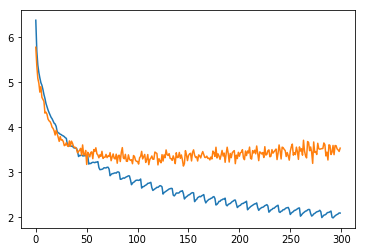

In [13]:
plt.plot(plot_losses_train)
plt.plot(plot_losses_test)
plt.show()

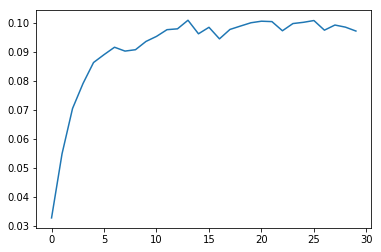

In [14]:
plt.plot(plot_bleu)
plt.show()

In [15]:
plot_bleu

[0.032692169458350656,
 0.054783576289205875,
 0.07038875327918911,
 0.07901932010523886,
 0.08623569830347134,
 0.08894796846095963,
 0.09150615513452351,
 0.0901765944332376,
 0.0906559566526957,
 0.0935078112643436,
 0.09523994293461313,
 0.09755536292829105,
 0.09784570117859946,
 0.10080674039668758,
 0.09613591867528334,
 0.09837562651682805,
 0.09439238647790911,
 0.09763815058343524,
 0.09880356272035357,
 0.09994011269417259,
 0.10047674606320195,
 0.10033710519823434,
 0.09718207112846425,
 0.09966917212017123,
 0.1000929278273504,
 0.10070583437026467,
 0.09738648490581986,
 0.0991551280993469,
 0.09842931378897646,
 0.0970858980829732]